# 라이브러리 불러오기

In [108]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import catboost
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from lightgbm import LGBMClassifier
from tqdm import tqdm
import time

In [723]:
train = pd.read_csv(r'..\Data\train.csv')
test = pd.read_csv(r'..\Data\test.csv')
submission = pd.read_csv(r'..\Data\sample_submission.csv')

# Feature 설명

index

gender: 성별   (o)

car: 차량 소유 여부   (o)

reality: 부동산 소유 여부   (o)

child_num: 자녀 수   

income_total: 연간 소득  (o)

income_type: 소득 분류   
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   

edu_type: 교육 수준   
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   

family_type: 결혼 여부   
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   

house_type: 생활 방식   
    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   

DAYS_BIRTH: 출생일   (o)
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   

DAYS_EMPLOYED: 업무 시작일   (o)   
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   

FLAG_MOBIL: 핸드폰 소유 여부  (o) 

work_phone: 업무용 전화 소유 여부   (o)

phone: 전화 소유 여부  (o) 

email: 이메일 소유 여부   (o)

occyp_type: 직업 유형	   												

family_size: 가족 규모  (o) 

begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미 (o)     

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   

In [724]:
print(train.shape)
print(test.shape)
train.info()

(26457, 20)
(10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-n

# 데이터 전처리
## 0. 중복 데이터 처리

In [725]:
cols = train.columns

In [726]:
train_and_test = [train, test]
for dataset in train_and_test:
  dataset['begin_month'] = dataset['begin_month'].abs()

In [727]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]

In [728]:
# list_card = []
# df_dup = train[train['identity']==train['identity'][3]]
# card_no = len(df_dup)
# list_card.append(card_no)

In [729]:
train_new = pd.DataFrame(columns=cols)

In [730]:
id = train['identity'].unique()

In [731]:
list_card_train = []
for i in range(len(train)):
    df_dup = train[train['identity']==train['identity'][i]]
    card_no = len(df_dup)
    list_card_train.append(card_no)


In [732]:
train['card_no'] = list_card_train

In [733]:
train['card_no']

0        5
1        9
2        6
3        2
4        1
        ..
26452    5
26453    1
26454    1
26455    1
26456    1
Name: card_no, Length: 26457, dtype: int64

In [734]:
list_card_test = []
for i in range(len(test)):
    df_dup = test[test['identity']==test['identity'][i]]
    card_no = len(df_dup)
    list_card_test.append(card_no)


In [735]:
test['card_no'] = list_card_test

In [736]:
test['card_no']

0       3
1       2
2       2
3       1
4       1
       ..
9995    3
9996    2
9997    5
9998    3
9999    1
Name: card_no, Length: 10000, dtype: int64

In [738]:
df = train[['begin_month', 'card_no']]
df_1 = df.corr()

In [739]:
print(df_1)

             begin_month   card_no
begin_month     1.000000  0.033894
card_no         0.033894  1.000000


In [562]:
for i in range(len(id_train)):
  df_dup = train[train['identity']==id_train[i]]
  if len(df_dup) != 1:
    df_cand = df_dup[df_dup['begin_month'] == df_dup['begin_month'].min()]
    if len(df_cand) != 1:
      mod = df_cand['begin_month'].mode()
      df = df_cand[df_cand['credit'] == float(mod)]
      if len(df) != 1:
        df_filtered = df = df_cand[df_cand['index'] == df_cand['index'].min()]
        train_new = pd.concat([train_new, df_filtered], axis=0)
      else:
        pass
    else:
      train_new = pd.concat([train_new, df_cand], axis=0)
  else:
    train_new = pd.concat([train_new, df_dup], axis=0)

In [563]:
train = train_new.sort_values('index')
train_and_test = [train, test]

In [564]:
train.index = np.arange(0, 8717, 1)

In [565]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity,card_no
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,...,1,0,0,0,NaN,2.0,6.0,1.0,F202500.0Commercial associate-13899-4709,5.0
1,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,1,0,1,0,Sales staff,2.0,37.0,0.0,F202500.0Commercial associate-15088-2092,2.0
2,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,1,0,0,0,Managers,2.0,26.0,2.0,F157500.0State servant-15037-2105,1.0
3,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,1,High skill tech staff,4.0,18.0,1.0,F270000.0Working-13413-4996,1.0
4,9,F,N,Y,0,103500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Medicine staff,2.0,5.0,2.0,F103500.0Working-15785-1308,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8712,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Core staff,4.0,2.0,1.0,F225000.0State servant-12079-1984,5.0
8713,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,...,1,0,0,0,NaN,2.0,47.0,2.0,F180000.0Working-15291-2475,1.0
8714,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,...,1,0,0,0,Core staff,2.0,25.0,2.0,F292500.0Working-10082-2015,1.0
8715,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,...,1,0,0,0,Laborers,1.0,59.0,2.0,M171000.0Working-10145-107,1.0


In [566]:
train.nunique()

index            8717
gender              2
car                 2
reality             2
child_num           9
income_total      249
income_type         5
edu_type            5
family_type         5
house_type          6
DAYS_BIRTH       6616
DAYS_EMPLOYED    3470
FLAG_MOBIL          1
work_phone          2
phone               2
email               2
occyp_type         18
family_size        10
begin_month        61
credit              3
identity         8717
card_no            23
dtype: int64

## 1. 데이터 전처리

In [567]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       2662
family_size         0
begin_month         0
credit              0
identity            0
card_no             0
dtype: int64

In [568]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit', 'identity',
       'card_no'],
      dtype='object')

## - Child_num: 자녀의 유무로 구분 (nominal)

<AxesSubplot:>

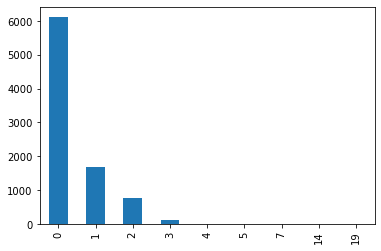

In [569]:
train['child_num'].value_counts(sort=False).plot.bar()

In [570]:
for dataset in train_and_test:
    dataset.loc[dataset['child_num'] != 0, 'child_num'] = 'kids_no'
    dataset.loc[dataset['child_num'] == 0, 'child_num'] = 'kids_yes'

# a for no kids/ b for whom has kids

## - income_total (ordinal)

(array([5.583e+03, 2.539e+03, 4.770e+02, 6.000e+01, 3.600e+01, 1.700e+01,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <BarContainer object of 10 artists>)

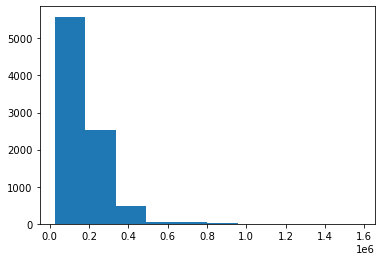

In [571]:
plt.hist(train['income_total'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2318e3b8c88>,
 'caps': [<matplotlib.lines.Line2D at 0x2318e3c0278>,
 'boxes': [<matplotlib.lines.Line2D at 0x2318e3b8a20>],
 'medians': [<matplotlib.lines.Line2D at 0x2318e3c0828>],
 'fliers': [<matplotlib.lines.Line2D at 0x2318e3c0b00>],
 'means': []}

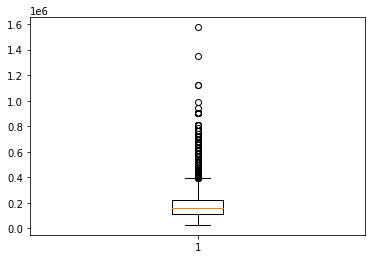

In [572]:
plt.boxplot(train['income_total']) # 이상치가 존재하나 범주형 데이터로 변형할 것이기에 그대로 사용한다.

In [573]:
## for lgbm: min-max scaling
# train_and_test = [train, test]
# for dataset in train_and_test:
#     scaler = MinMaxScaler()
#     income_fitted = scaler.fit_transform(dataset[['income_total']])
#     dataset['income_total'] = income_fitted

In [575]:
# for lgbm: std scailing
train_and_test = [train, test]
for dataset in train_and_test:
    scaler = StandardScaler()
    income_fitted = scaler.fit_transform(dataset[['income_total']])
    dataset['income_total'] = income_fitted

In [442]:
# # for Catboost
# for dataset in train_and_test:
#     Q1 = dataset['income_total'].quantile(0.2)
#     Q2 = dataset['income_total'].quantile(0.4)
#     Q3 = dataset['income_total'].quantile(0.6)
#     Q4 = dataset['income_total'].quantile(0.8)
#     Q5 = dataset['income_total'].quantile(1.0)
#     bins_income = [0, Q1, Q2, Q3, Q4, Q5]
#     labels_income = ['a', 'b', 'c', 'd', 'e']
#     cuts = pd.cut(dataset['income_total'], bins = bins_income, labels = labels_income, include_lowest= True)
#     dataset['income_total'] = cuts

In [576]:
test['income_total'].isnull().sum()

0

## - Discrete variables

## - fanily_size (ordinal)

In [577]:
train['family_size'].value_counts()

2.0     4637
1.0     1752
3.0     1479
4.0      720
5.0      108
6.0       16
7.0        2
9.0        1
15.0       1
20.0       1
Name: family_size, dtype: int64

(array([1878., 5357.,    0., 1789.,    0.,  846.,  106.,    0.,   14.,
          10.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

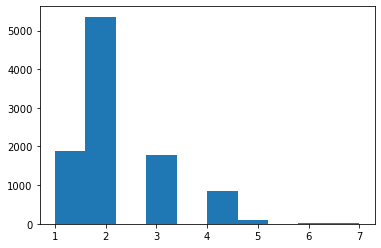

In [581]:
plt.hist(test['family_size'])

In [584]:
train['family_size'].describe()

count    8717.000000
mean        2.183894
std         0.936010
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: family_size, dtype: float64

In [585]:
for dataset in train_and_test:
    bins_family = [0, 1, 2, 21]
    labels_family = ['a', 'b', 'c']
    cuts = pd.cut(dataset['family_size'], bins = bins_family, labels = labels_family)
    dataset['family_size'] = cuts

# a for single, b for double, c for more than double

In [586]:
test['family_size']

0       b
1       b
2       b
3       b
4       b
       ..
9995    b
9996    b
9997    b
9998    b
9999    b
Name: family_size, Length: 10000, dtype: category
Categories (3, object): ['a' < 'b' < 'c']

## - income_type (nominal)

In [591]:
train['income_type'].value_counts()

Working                 4498
Commercial associate    2055
Pensioner               1507
State servant            654
Student                    3
Name: income_type, dtype: int64

In [592]:
for dataset in train_and_test:
    dataset.loc[dataset['income_type']=='Student', 'income_type'] = 'Working' # ==> student 데이터의 수가 적고 working 데이터가 크고 다양하다는 점에서 편입함.

In [593]:
test['income_type'].unique()

array(['Pensioner', 'State servant', 'Working', 'Commercial associate'],
      dtype=object)

## - edu_type (ordinal)

In [594]:
test['edu_type'].value_counts()

Secondary / secondary special    6782
Higher education                 2702
Incomplete higher                 390
Lower secondary                   117
Academic degree                     9
Name: edu_type, dtype: int64

In [595]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,identity,card_no
0,26457,M,Y,N,kids_yes,-0.714468,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,365243,1,0,1,0,NaN,b,60.0,M112500.0Pensioner-21990365243,3
1,26458,F,N,Y,kids_yes,-0.492869,State servant,Higher education,Married,House / apartment,...,-8671,1,0,1,0,Core staff,b,36.0,F135000.0State servant-18964-8671,2
2,26459,F,N,Y,kids_yes,-1.139229,Working,Secondary / secondary special,Married,House / apartment,...,-217,1,1,1,0,Laborers,b,40.0,F69372.0Working-15887-217,2
3,26460,M,Y,N,kids_yes,-0.714468,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-2531,1,1,0,0,Drivers,b,41.0,M112500.0Commercial associate-19270-2531,1
4,26461,F,Y,Y,kids_yes,0.393527,State servant,Higher education,Married,House / apartment,...,-9385,1,1,0,0,Managers,b,8.0,F225000.0State servant-17822-9385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,kids_yes,0.171928,Working,Incomplete higher,Married,House / apartment,...,-5434,1,1,1,0,Accountants,b,19.0,F202500.0Working-18593-5434,3
9996,36453,M,Y,Y,kids_yes,0.171928,Working,Secondary / secondary special,Civil marriage,House / apartment,...,-1315,1,1,0,0,Laborers,b,34.0,M202500.0Working-10886-1315,2
9997,36454,F,N,Y,kids_yes,1.058325,Working,Secondary / secondary special,Married,House / apartment,...,-14018,1,0,0,0,Medicine staff,b,55.0,F292500.0Working-21016-14018,5
9998,36455,F,Y,N,kids_yes,-0.049671,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-1085,1,0,1,0,NaN,b,33.0,F180000.0Commercial associate-16541-1085,3


In [596]:
test.groupby(['edu_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 석박사 과정과 대졸의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

edu_type                       income_total  income_total
Academic degree                -0.492869     -0.492869       2
                                0.836725      0.836725       4
                                1.501523      1.501523       3
Higher education               -1.556545     -1.556545       1
                               -1.459041     -1.459041       2
                                                            ..
Secondary / secondary special   4.205032      4.205032       3
                                4.382311      4.382311       6
                                4.825509      4.825509       8
                                6.155104      6.155104       1
                                7.041500      7.041500       6
Name: income_total, Length: 356, dtype: int64

In [597]:
for dataset in train_and_test:
    dataset.loc[dataset['edu_type']=='Academic degree', 'edu_type'] = 'Higher education'
    dataset.loc[dataset['edu_type']=='Lower secondary', 'edu_type'] = 'Secondary / secondary special'

In [598]:
train['edu_type'].value_counts()

Secondary / secondary special    6142
Higher education                 2241
Incomplete higher                 334
Name: edu_type, dtype: int64

In [599]:
for dataset in train_and_test:
  dataset.loc[dataset['edu_type'] == 'Secondary / secondary special', 'edu_type'] = 'a'
  dataset.loc[dataset['edu_type'] == 'Incomplete higher', 'edu_type'] = 'b'
  dataset.loc[dataset['edu_type'] == 'Higher education', 'edu_type'] = 'c'

In [600]:
test['edu_type']

0       a
1       c
2       a
3       a
4       c
       ..
9995    b
9996    a
9997    a
9998    a
9999    c
Name: edu_type, Length: 10000, dtype: object

## - family_type (nominal)

In [601]:
train['family_type'].value_counts()

Married                 5884
Single / not married    1217
Civil marriage           736
Separated                518
Widow                    362
Name: family_type, dtype: int64

## - house_type (nominal)

In [602]:
# test['house_type'].value_counts()
test['house_type'].unique()

array(['House / apartment', 'With parents', 'Rented apartment',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [603]:
test.groupby(['house_type', 'income_total'])['income_total'].value_counts() # 확인해본 결과 아파트 종류들의 소득 분포가 큰 차이를 보이지 않기에 데이터를 합침.

house_type       income_total  income_total
Co-op apartment  -1.157666     -1.157666       1
                 -0.980387     -0.980387       3
                 -0.936067     -0.936067       5
                 -0.847428     -0.847428       2
                 -0.758788     -0.758788       1
                                              ..
With parents      1.944721      1.944721       2
                  2.166320      2.166320       8
                  2.609518      2.609518       2
                  2.831117      2.831117       1
                  3.939113      3.939113       3
Name: income_total, Length: 370, dtype: int64

In [604]:
for dataset in train_and_test:
    houses = ['Municipal apartment', 'Co-op apartment', 'Rented apartment', 'Office apartment']
    for type in houses:
        dataset.loc[dataset['house_type']==type, 'house_type'] = 'etc_apartment'

In [605]:
test.nunique()

index            10000
gender               2
car                  2
reality              2
child_num            2
income_total       208
income_type          4
edu_type             3
family_type          5
house_type           3
DAYS_BIRTH        4675
DAYS_EMPLOYED     2665
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          18
family_size          3
begin_month         61
identity          5571
card_no             12
dtype: int64

## - DAYS_EMPLOYED (ordinal)
-  근무일수 데이터 중 양수의 값을 가지는 데이터를 0->Unemployed로 바꾼 후 각 분위에 해당하는 데이터를 'Short', 'Medium', 'Long', 'Very_Long'로 변환함.

 - [a < b < c < d < e] -> ['Unemployed', 'Short', 'Medium', 'Long']

In [606]:
# 'DAYS_EMPLOYED' preprocessing
for dataset in train_and_test:
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
    dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].abs()

    Q1 = dataset['DAYS_EMPLOYED'].quantile(0.33)
    Q2 = dataset['DAYS_EMPLOYED'].quantile(0.66)

    bins = [0, 1, Q1, Q2, 15713]
    labels = ['a', 'b', 'c', 'd']
    cuts = pd.cut(dataset['DAYS_EMPLOYED'], bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_EMPLOYED'] = cuts


In [607]:
train['DAYS_EMPLOYED'].unique()

['d', 'c', 'b', 'a']
Categories (4, object): ['a' < 'b' < 'c' < 'd']

### Min-max scailing

In [466]:
# for dataset in train_and_test:
#     dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
#     dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].abs()
#     employed_fitted = scaler.fit_transform(dataset[['DAYS_EMPLOYED']])
#     dataset['DAYS_EMPLOYED'] = employed_fitted

In [608]:
train['DAYS_EMPLOYED'].value_counts()

d    2964
c    2869
a    1496
b    1388
Name: DAYS_EMPLOYED, dtype: int64

In [609]:
test['DAYS_EMPLOYED'].isnull().sum()

0

## - DAYS_BIRTH: (ordinal)
살아온 일수를 절대값을 취한 후 연단위로 바꾸어 반올림함.

 - ['20s', '30s', '40s', '50s', '60s'] => ['a', 'b', 'c', 'd', 'e']

In [611]:
for dataset in train_and_test:
    dataset['DAYS_BIRTH'] = (dataset['DAYS_BIRTH']/365).abs().astype(object)
    bins = [20, 30, 40, 50, 60, 70]
    labels = ['a', 'b', 'c', 'd', 'e']
    cuts = pd.cut(dataset['DAYS_BIRTH'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['DAYS_BIRTH'] = cuts
    # pd.get_dummies(dataset['DAYS_BIRTH'])

In [612]:
# for dataset in train_and_test:
#     dataset['DAYS_BIRTH'].abs()
#     birth_fitted = scaler.fit_transform(dataset[['DAYS_BIRTH']])
#     dataset['DAYS_BIRTH'] = birth_fitted

In [613]:
test['DAYS_BIRTH'].isnull().sum()

0

In [614]:
dataset['DAYS_BIRTH'].value_counts()

b    2851
c    2543
d    2213
a    1320
e    1073
Name: DAYS_BIRTH, dtype: int64

In [615]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8717 entries, 0 to 8716
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          8717 non-null   object  
 1   gender         8717 non-null   object  
 2   car            8717 non-null   object  
 3   reality        8717 non-null   object  
 4   child_num      8717 non-null   object  
 5   income_total   8717 non-null   float64 
 6   income_type    8717 non-null   object  
 7   edu_type       8717 non-null   object  
 8   family_type    8717 non-null   object  
 9   house_type     8717 non-null   object  
 10  DAYS_BIRTH     8717 non-null   category
 11  DAYS_EMPLOYED  8717 non-null   category
 12  FLAG_MOBIL     8717 non-null   object  
 13  work_phone     8717 non-null   object  
 14  phone          8717 non-null   object  
 15  email          8717 non-null   object  
 16  occyp_type     6055 non-null   object  
 17  family_size    8717 non-null   ca

## occupation (nominal)

In [616]:
test.occyp_type.value_counts()

Laborers                 1699
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
High skill tech staff     343
Medicine staff            343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning staff            148
Private service staff     101
Secretaries                54
Waiters/barmen staff       50
Low-skill Laborers         48
HR staff                   23
IT staff                   19
Realty agents              16
Name: occyp_type, dtype: int64

In [617]:
train['occyp_type'] = train['occyp_type'].fillna('no')
test['occyp_type'] = test['occyp_type'].fillna('no')

In [618]:
test['occyp_type'].isnull().sum()

0

In [619]:
for dataset in train_and_test:
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] != 'a'), 'occyp_type'] = 'no_response'
    dataset.loc[(dataset['occyp_type'] == 'no')&(dataset['DAYS_EMPLOYED'] == 'a'), 'occyp_type'] = 'no_job'

In [620]:
train['occyp_type'].isnull().sum()

0

In [621]:
for dataset in train_and_test:
  dataset['occyp_type'] = dataset['occyp_type'].replace(['Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff'], 'etc')

In [622]:
train['occyp_type'].value_counts()

Laborers                 1548
no_job                   1496
no_response              1166
Sales staff               867
Core staff                787
Managers                  708
Drivers                   560
High skill tech staff     327
Accountants               277
Medicine staff            265
etc                       254
Cooking staff             173
Security staff            155
Cleaning staff            134
Name: occyp_type, dtype: int64

In [623]:
train['occyp_type'].value_counts()

Laborers                 1548
no_job                   1496
no_response              1166
Sales staff               867
Core staff                787
Managers                  708
Drivers                   560
High skill tech staff     327
Accountants               277
Medicine staff            265
etc                       254
Cooking staff             173
Security staff            155
Cleaning staff            134
Name: occyp_type, dtype: int64

## begin_month (ordinal)
### 음수 값을 가진 데이터를 절대값을 취해주었으며, 0의 값을 가진 데이터의 경우 카드를 소지하지 않은 경우로 판단함.

In [624]:
# train['begin_month'].describe()

In [625]:
# train['begin_month'].head()
# train['begin_month'].describe() # 0의 값이 존재함 -> 어떤 의미? -> 카드를 발급받지 아니한 사람 (사유: 다양함 --> 신용불량, 소득 X, 신용등급이 낮은 사회 초년생 등)
# train['begin_month'].isnull().sum() # 결측치 없음
# len(train.loc[train['begin_month'] == 0, :]) # 카드를 소지하지 않은 사람의 수가 231명으로 보임.

In [626]:
# train['begin_month'] = train['begin_month'].abs()/12 # 음수 값을 가지던 데이터에 절대값처리.

In [627]:
# train['begin_month'].value_counts

- ['NoCard', '0_year', '1_year', '2_year', '3_year', '4+_years'] => ['a', 'b', 'c', 'd', 'e', 'f']

In [713]:
# for catboost
for dataset in train_and_test:
    dataset['begin_month'] = dataset['begin_month']/12
    bins = [0, 0.001, 1, 2, 3, 4, 5]
    labels = ['a', 'b', 'c', 'd', 'e', 'f']
    cuts = pd.cut(dataset['begin_month'], bins = bins, right=True, labels=labels, include_lowest= True)
    dataset['begin_month'] = cuts

In [714]:
train['begin_month'].unique()

['b', 'c', 'e', 'd', 'f', 'a']
Categories (6, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f']

In [715]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,identity,card_no
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,365243,1,0,1,0,NaN,2.0,f,M112500.0Pensioner-21990365243,3
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,...,-8671,1,0,1,0,Core staff,2.0,d,F135000.0State servant-18964-8671,2
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,...,-217,1,1,1,0,Laborers,2.0,e,F69372.0Working-15887-217,2
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-2531,1,1,0,0,Drivers,2.0,e,M112500.0Commercial associate-19270-2531,1
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,...,-9385,1,1,0,0,Managers,2.0,b,F225000.0State servant-17822-9385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,...,-5434,1,1,1,0,Accountants,2.0,c,F202500.0Working-18593-5434,3
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,-1315,1,1,0,0,Laborers,2.0,d,M202500.0Working-10886-1315,2
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,...,-14018,1,0,0,0,Medicine staff,2.0,f,F292500.0Working-21016-14018,5
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-1085,1,0,1,0,NaN,2.0,d,F180000.0Commercial associate-16541-1085,3


In [631]:
## for lgbm
# for dataset in train_and_test:
#     dataset['begin_month'] = dataset['begin_month'].abs()
#     month_fitted = scaler.fit_transform(dataset[['begin_month']])
#     dataset['begin_month'] = month_fitted

In [632]:
train['begin_month']

0       b
1       e
2       d
3       c
4       b
       ..
8712    b
8713    e
8714    d
8715    f
8716    b
Name: begin_month, Length: 8717, dtype: category
Categories (6, object): ['a' < 'b' < 'c' < 'd' < 'e' < 'f']

In [633]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          10000 non-null  int64   
 1   gender         10000 non-null  object  
 2   car            10000 non-null  object  
 3   reality        10000 non-null  object  
 4   child_num      10000 non-null  object  
 5   income_total   10000 non-null  float64 
 6   income_type    10000 non-null  object  
 7   edu_type       10000 non-null  object  
 8   family_type    10000 non-null  object  
 9   house_type     10000 non-null  object  
 10  DAYS_BIRTH     10000 non-null  category
 11  DAYS_EMPLOYED  10000 non-null  category
 12  FLAG_MOBIL     10000 non-null  int64   
 13  work_phone     10000 non-null  int64   
 14  phone          10000 non-null  int64   
 15  email          10000 non-null  int64   
 16  occyp_type     10000 non-null  object  
 17  family_size    10000 non-null  c

## 트레인 테스트 셋으로 전처리

In [634]:
train.index = np.arange(0, 8717, 1)

In [635]:
test.index = np.arange(0, 10000, 1)

In [637]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity,card_no
0,0,F,N,N,kids_yes,0.204425,Commercial associate,c,Married,etc_apartment,...,1,0,0,0,no_response,b,b,1.0,F202500.0Commercial associate-13899-4709,5.0
1,3,F,N,Y,kids_yes,0.204425,Commercial associate,a,Married,House / apartment,...,1,0,1,0,Sales staff,b,e,0.0,F202500.0Commercial associate-15088-2092,2.0
2,4,F,Y,Y,kids_yes,-0.243259,State servant,c,Married,House / apartment,...,1,0,0,0,Managers,b,d,2.0,F157500.0State servant-15037-2105,1.0
3,5,F,N,Y,kids_no,0.875951,Working,a,Married,House / apartment,...,1,0,0,1,High skill tech staff,c,c,1.0,F270000.0Working-13413-4996,1.0
4,9,F,N,Y,kids_yes,-0.780480,Working,a,Married,House / apartment,...,1,0,0,0,Medicine staff,b,b,2.0,F103500.0Working-15785-1308,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8712,26452,F,N,N,kids_no,0.428267,State servant,a,Married,House / apartment,...,1,0,0,0,Core staff,c,b,1.0,F225000.0State servant-12079-1984,5.0
8713,26453,F,N,Y,kids_no,-0.019417,Working,c,Separated,House / apartment,...,1,0,0,0,no_response,b,e,2.0,F180000.0Working-15291-2475,1.0
8714,26454,F,Y,N,kids_yes,1.099793,Working,a,Civil marriage,With parents,...,1,0,0,0,Core staff,b,d,2.0,F292500.0Working-10082-2015,1.0
8715,26455,M,N,Y,kids_yes,-0.108954,Working,b,Single / not married,House / apartment,...,1,0,0,0,Laborers,a,f,2.0,M171000.0Working-10145-107,1.0


In [638]:
train_x = train.drop(['credit', 'index', 'identity', 'FLAG_MOBIL'], axis = 1)
train_y = train[['credit']]
test_x = test.drop(['index', 'FLAG_MOBIL'], axis = 1)

In [639]:
# for catboost
feat_ordinal = ['begin_month', 'edu_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'work_phone', 'phone', 'email','card_no']
feat_nominal = ['car', 'reality', 'child_num', 'income_type', 'family_type', 'house_type', 'occyp_type']

In [640]:
# # for lgbm
# feat_ordinal = ['edu_type', 'DAYS_BIRTH', 'family_size']
# feat_nominal = ['car', 'reality', 'child_num', 'income_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type' ]

In [641]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,card_no
0,F,N,N,kids_yes,0.204425,Commercial associate,c,Married,etc_apartment,b,d,0,0,0,no_response,b,b,5.0
1,F,N,Y,kids_yes,0.204425,Commercial associate,a,Married,House / apartment,c,c,0,1,0,Sales staff,b,e,2.0
2,F,Y,Y,kids_yes,-0.243259,State servant,c,Married,House / apartment,c,c,0,0,0,Managers,b,d,1.0
3,F,N,Y,kids_no,0.875951,Working,a,Married,House / apartment,b,d,0,0,1,High skill tech staff,c,c,1.0
4,F,N,Y,kids_yes,-0.780480,Working,a,Married,House / apartment,c,c,0,0,0,Medicine staff,b,b,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8712,F,N,N,kids_no,0.428267,State servant,a,Married,House / apartment,b,c,0,0,0,Core staff,c,b,5.0
8713,F,N,Y,kids_no,-0.019417,Working,c,Separated,House / apartment,c,d,0,0,0,no_response,b,e,1.0
8714,F,Y,N,kids_yes,1.099793,Working,a,Civil marriage,With parents,a,c,0,0,0,Core staff,b,d,1.0
8715,M,N,Y,kids_yes,-0.108954,Working,b,Single / not married,House / apartment,a,b,0,0,0,Laborers,a,f,1.0


In [642]:
train_nom = pd.get_dummies(train_x[feat_nominal], drop_first=True) 
train_ord = train_x[feat_ordinal]
encoder = OrdinalEncoder()
encoder.fit(train_ord.values.tolist())
train_ord_encoded = encoder.transform(train_ord.values.tolist())
train_ord = pd.DataFrame(train_ord_encoded, columns= feat_ordinal)
train_x = pd.concat([train_nom, train_ord], axis = 1)

In [651]:
train_x = pd.concat([train_x, train['income_total']], axis = 1)

In [643]:
test_nom = pd.get_dummies(test_x[feat_nominal], drop_first=True) 
test_ord = test_x[feat_ordinal]
encoder = OrdinalEncoder()
encoder.fit(test_ord.values.tolist())
test_ord_encoded = encoder.transform(test_ord.values.tolist())
test_ord = pd.DataFrame(test_ord_encoded, columns= feat_ordinal)
test_x = pd.concat([test_nom, test_ord], axis = 1)

In [655]:
test_x = pd.concat([test_x, test['income_total']], axis = 1)

In [657]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8717 entries, 0 to 8716
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   car_Y                             8717 non-null   uint8  
 1   reality_Y                         8717 non-null   uint8  
 2   child_num_kids_yes                8717 non-null   uint8  
 3   income_type_Pensioner             8717 non-null   uint8  
 4   income_type_State servant         8717 non-null   uint8  
 5   income_type_Working               8717 non-null   uint8  
 6   family_type_Married               8717 non-null   uint8  
 7   family_type_Separated             8717 non-null   uint8  
 8   family_type_Single / not married  8717 non-null   uint8  
 9   family_type_Widow                 8717 non-null   uint8  
 10  house_type_With parents           8717 non-null   uint8  
 11  house_type_etc_apartment          8717 non-null   uint8  
 12  occyp_

In [658]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   car_Y                             10000 non-null  uint8  
 1   reality_Y                         10000 non-null  uint8  
 2   child_num_kids_yes                10000 non-null  uint8  
 3   income_type_Pensioner             10000 non-null  uint8  
 4   income_type_State servant         10000 non-null  uint8  
 5   income_type_Working               10000 non-null  uint8  
 6   family_type_Married               10000 non-null  uint8  
 7   family_type_Separated             10000 non-null  uint8  
 8   family_type_Single / not married  10000 non-null  uint8  
 9   family_type_Widow                 10000 non-null  uint8  
 10  house_type_With parents           10000 non-null  uint8  
 11  house_type_etc_apartment          10000 non-null  uint8  
 12  occyp

# [데이터 모델링]

In [659]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8717 entries, 0 to 8716
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   car_Y                             8717 non-null   uint8  
 1   reality_Y                         8717 non-null   uint8  
 2   child_num_kids_yes                8717 non-null   uint8  
 3   income_type_Pensioner             8717 non-null   uint8  
 4   income_type_State servant         8717 non-null   uint8  
 5   income_type_Working               8717 non-null   uint8  
 6   family_type_Married               8717 non-null   uint8  
 7   family_type_Separated             8717 non-null   uint8  
 8   family_type_Single / not married  8717 non-null   uint8  
 9   family_type_Widow                 8717 non-null   uint8  
 10  house_type_With parents           8717 non-null   uint8  
 11  house_type_etc_apartment          8717 non-null   uint8  
 12  occyp_

In [660]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   car_Y                             10000 non-null  uint8  
 1   reality_Y                         10000 non-null  uint8  
 2   child_num_kids_yes                10000 non-null  uint8  
 3   income_type_Pensioner             10000 non-null  uint8  
 4   income_type_State servant         10000 non-null  uint8  
 5   income_type_Working               10000 non-null  uint8  
 6   family_type_Married               10000 non-null  uint8  
 7   family_type_Separated             10000 non-null  uint8  
 8   family_type_Single / not married  10000 non-null  uint8  
 9   family_type_Widow                 10000 non-null  uint8  
 10  house_type_With parents           10000 non-null  uint8  
 11  house_type_etc_apartment          10000 non-null  uint8  
 12  occyp

In [661]:
print(train_x.shape, test_x.shape, train_y.shape)

(8717, 35) (10000, 35) (8717, 1)


In [662]:
train.isnull().sum()

index            0
gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
identity         0
card_no          0
dtype: int64

## UPSAMPLING
- LEARNING....

In [663]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score


X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(6537, 35)
(6537, 1)
Validation set: 
(2180, 35)
(2180, 1)


In [664]:
# rf_clf=RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
# y_pred_rf=rf_clf.predict_proba(X_val)
# rf_clf.classes_

# # print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_rf)}")

In [665]:
# gbm_clf=GradientBoostingClassifier()
# gbm_clf.fit(X_train, y_train)
# y_pred_gbm=gbm_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_gbm)}")

In [666]:
# ada_clf=AdaBoostClassifier()
# ada_clf.fit(X_train, y_train)
# y_pred_ada=ada_clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_ada)}")

In [667]:
# lgbm_clf = LGBMClassifier()
# lgbm_clf.fit(X_train, y_train)
# y_pred_lgbm = lgbm_clf.predict_proba(X_val)


# print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
# print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_lgbm)}")

In [668]:
# sort.value

In [669]:
cbt_clf = CatBoostClassifier()
cbt_clf.fit(X_train, y_train)
y_pred_cbt = cbt_clf.predict_proba(X_val)


print("훈련 세트 정확도: {:.3f}".format(cbt_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cbt_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred_cbt)}")

Learning rate set to 0.087078
0:	learn: 1.0621516	total: 9.18ms	remaining: 9.17s
1:	learn: 1.0319740	total: 12.6ms	remaining: 6.31s
2:	learn: 1.0074189	total: 20.2ms	remaining: 6.71s
3:	learn: 0.9853274	total: 37.5ms	remaining: 9.34s
4:	learn: 0.9666115	total: 45.2ms	remaining: 8.99s
5:	learn: 0.9505250	total: 54.1ms	remaining: 8.96s
6:	learn: 0.9368203	total: 60ms	remaining: 8.51s
7:	learn: 0.9254405	total: 65ms	remaining: 8.05s
8:	learn: 0.9164931	total: 71.1ms	remaining: 7.83s
9:	learn: 0.9085197	total: 77.4ms	remaining: 7.66s
10:	learn: 0.9013492	total: 85.9ms	remaining: 7.72s
11:	learn: 0.8954260	total: 91.2ms	remaining: 7.51s
12:	learn: 0.8898737	total: 98.6ms	remaining: 7.49s
13:	learn: 0.8847230	total: 105ms	remaining: 7.41s
14:	learn: 0.8802718	total: 111ms	remaining: 7.28s
15:	learn: 0.8768420	total: 130ms	remaining: 8.02s
16:	learn: 0.8734023	total: 136ms	remaining: 7.84s
17:	learn: 0.8703888	total: 141ms	remaining: 7.68s
18:	learn: 0.8677876	total: 147ms	remaining: 7.59s
19

<BarContainer object of 35 artists>

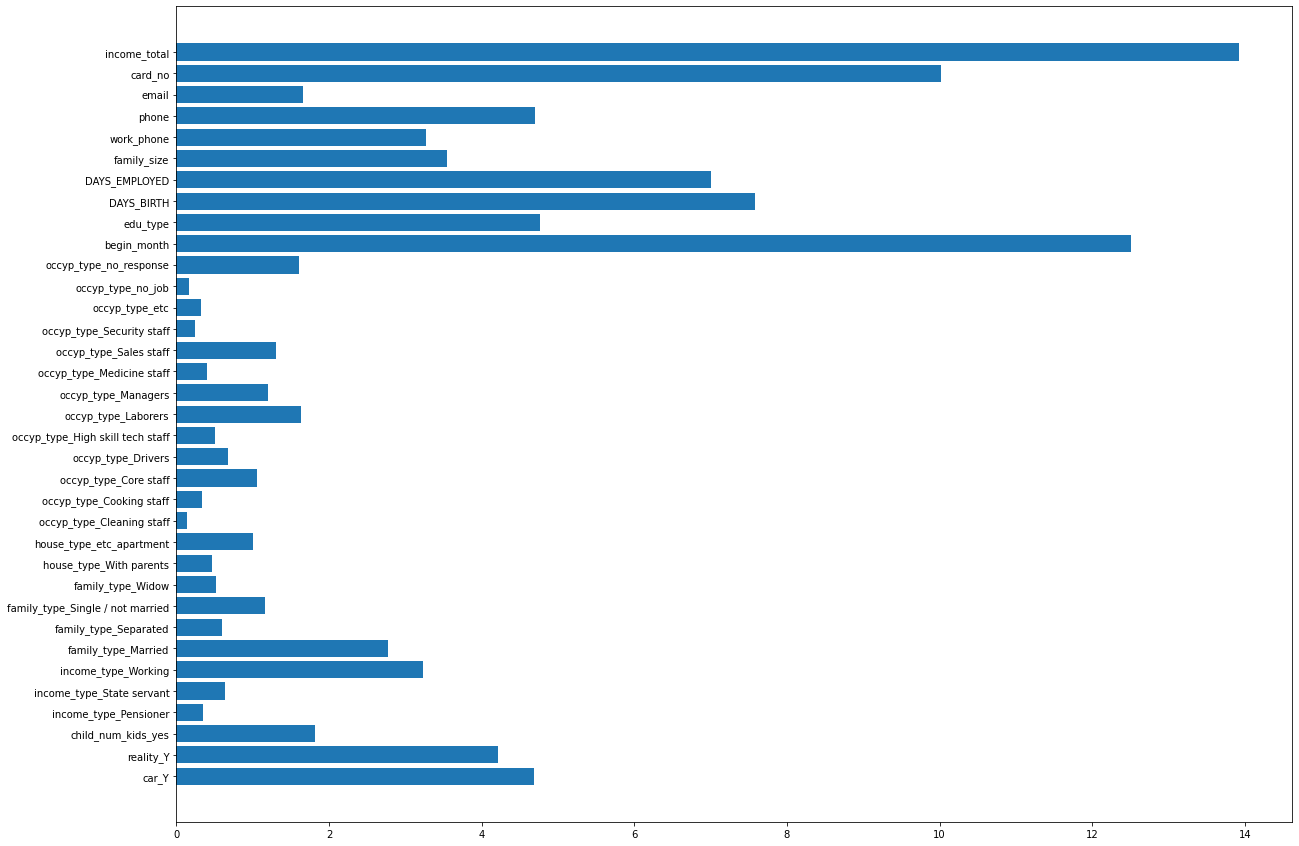

In [670]:
cbt_clf.get_feature_importance()

plt.figure(figsize=(20, 15))

plt.barh(X_train.columns, cbt_clf.get_feature_importance())

In [671]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cbt_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cbt_clf.fit(X_train, y_train)
        
        predictions=cbt_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cbt_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cbt_clf)

Learning rate set to 0.087365
0:	learn: 1.0619360	total: 13ms	remaining: 13s
1:	learn: 1.0315396	total: 19.2ms	remaining: 9.58s
2:	learn: 1.0068703	total: 25.3ms	remaining: 8.4s
3:	learn: 0.9848044	total: 33.8ms	remaining: 8.42s
4:	learn: 0.9660855	total: 40.4ms	remaining: 8.04s
5:	learn: 0.9504951	total: 48.6ms	remaining: 8.05s
6:	learn: 0.9381154	total: 54.1ms	remaining: 7.67s
7:	learn: 0.9266471	total: 58.3ms	remaining: 7.23s
8:	learn: 0.9177576	total: 66.6ms	remaining: 7.33s
9:	learn: 0.9096266	total: 72.1ms	remaining: 7.13s
10:	learn: 0.9025563	total: 79.2ms	remaining: 7.12s
11:	learn: 0.8966504	total: 86.9ms	remaining: 7.15s
12:	learn: 0.8912998	total: 91.1ms	remaining: 6.91s
13:	learn: 0.8864184	total: 114ms	remaining: 8.01s
14:	learn: 0.8823186	total: 119ms	remaining: 7.83s
15:	learn: 0.8787540	total: 126ms	remaining: 7.72s
16:	learn: 0.8750814	total: 131ms	remaining: 7.57s
17:	learn: 0.8717831	total: 137ms	remaining: 7.45s
18:	learn: 0.8692401	total: 144ms	remaining: 7.42s
19:

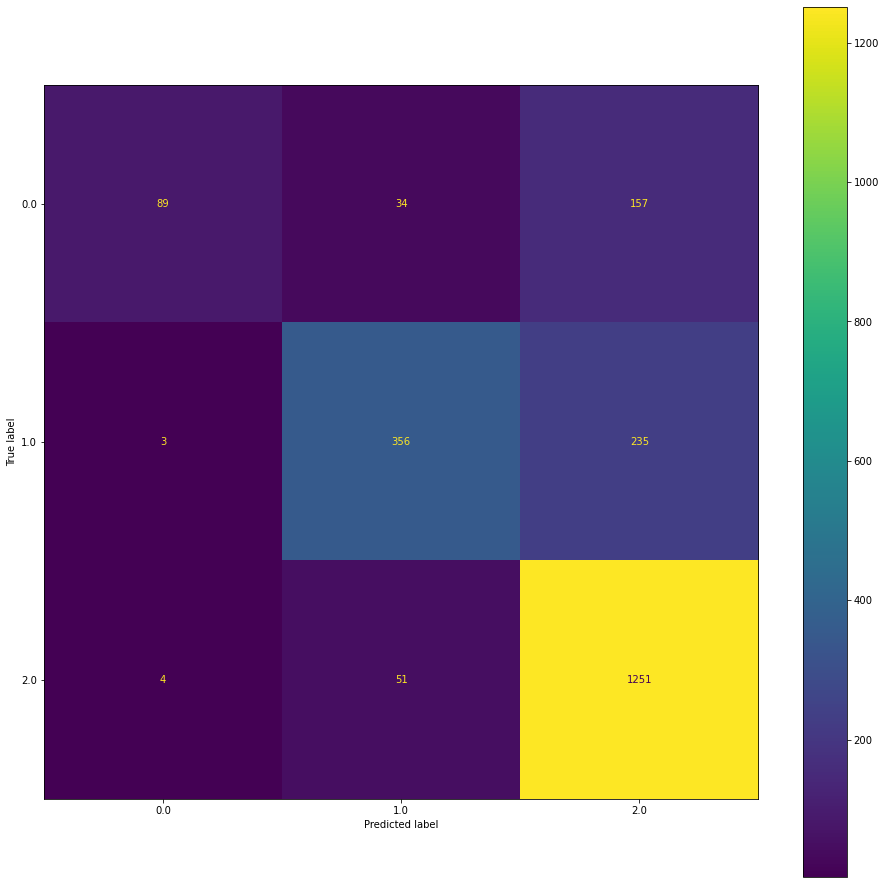

In [745]:
from sklearn.metrics import plot_confusion_matrix
plt.rcParams['figure.figsize'] = (16,16)
plot_confusion_matrix(cbt_clf, X_val, y_val)

In [672]:
my_submission

array([[0.10838632, 0.17821187, 0.71340182],
       [0.12516384, 0.09949361, 0.77534256],
       [0.12593406, 0.16844462, 0.70562133],
       ...,
       [0.04614984, 0.10679128, 0.84705888],
       [0.06258406, 0.09512674, 0.8422892 ],
       [0.03239945, 0.54140954, 0.42619101]])

In [673]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [674]:
submission.loc[:, 1:] = my_submission

In [675]:
submission

,index,0,1,2
0,26457,0.108386,0.178212,0.713402
1,26458,0.125164,0.099494,0.775343
2,26459,0.125934,0.168445,0.705621
3,26460,0.093173,0.048631,0.858196
4,26461,0.062989,0.298260,0.638750
...,...,...,...,...
9995,36452,0.125051,0.132631,0.742317
9996,36453,0.125156,0.152709,0.722134
9997,36454,0.046150,0.106791,0.847059
9998,36455,0.062584,0.095127,0.842289


In [676]:
# submission.to_csv(r'..\Data\submission_JH_cbt8.csv', index=False)